In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import seaborn
import numpy as np
import scipy.stats
import os

%pylab inline
    
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#Function for downloading data
def getCitiBikeCSV(datestring):
    #Check file
    if not os.path.isfile(puidata + "/" + datestring + "-citibike-tripdata.csv"):
        #Check zip
        if not os.path.isfile(puidata + "/" + datestring + "-citibike-tripdata.zip"):
            #Download zip and move to puidata
            print ("Downloading file") 
            os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
            os.system("mv " + datestring + "-citibike-tripdata.zip " + puidata)
        # Unzip and move to puidata
        print ("Unzipping file") 
        os.system("unzip " + puidata + "/" + datestring + "-citibike-tripdata.zip")
        os.system("mv " + datestring + "-citibike-tripdata.csv " + puidata)

    # Check:
    if not os.path.isfile(puidata + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! Something is wrong: the file is not there!")

    else:
        print ("File in place, you can continue")

In [3]:
#Define 2 months, one in summer and one in winter
jan2015 = '201501'
aug2015 = '201508'

#Download the data
getCitiBikeCSV(jan2015)
getCitiBikeCSV(aug2015)

File in place, you can continue
File in place, you can continue


In [58]:
#Read first month
df = pd.read_csv(puidata + "/" + jan2015 + '-citibike-tripdata.csv')

#Append second month
df = df.append(pd.read_csv(puidata + "/" + aug2015 + '-citibike-tripdata.csv'), ignore_index=True)

In [59]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [60]:
#Convert starttime to datetime
df['starttime_converted'] = pd.to_datetime(df['starttime'], infer_datetime_format=True)

### Hypothesis testing: Trip duration day vs night

$H_0$: There is no statistical difference in the trip durations between day and night rides, with a significance level of 0.05

To split trips between day and night I will use the starting time of the ride. If it was between sunrise and sunset it is classified as day and if not it is classified as night.

Each day has different sunrise and sunset times, but for simplification I will use the first day of the month.

From https://www.timeanddate.com this times are:

January 2015

    Sunrise 7:20 am
    Sunset 4:39 pm

August 2015

    Sunrise 5:52 am
    Sunset 8:11 pm

In [61]:
#Setting the datetimes
jan2015_sunrise = pd.Timestamp('2015-01-01 07:20')
jan2015_sunset = pd.Timestamp('2015-01-01 16:39')
aug2015_sunrise = pd.Timestamp('2015-08-01 05:52')
aug2015_sunset = pd.Timestamp('2015-08-01 20:11')

In [62]:
#Classify rows
df['day_or_night'] = ((df['starttime_converted'].dt.month == jan2015_sunrise.month) & \
                        (df['starttime_converted'].apply(lambda x: x.time()) > jan2015_sunrise.time()) & \
                        (df['starttime_converted'].apply(lambda x: x.time()) < jan2015_sunset.time())) | \
                        ((df['starttime_converted'].dt.month == aug2015_sunrise.month) & \
                        (df['starttime_converted'].apply(lambda x: x.time()) > aug2015_sunrise.time()) & \
                        (df['starttime_converted'].apply(lambda x: x.time()) < aug2015_sunset.time()))

df['day_or_night'] = df['day_or_night'].replace({True:'day', False:'night'})

In [63]:
df.day_or_night.value_counts()

day      1165900
night     298696
Name: day_or_night, dtype: int64

In [64]:
#Dropping data I don't need
df = df.loc[:,['tripduration','day_or_night','starttime_converted']]

In [65]:
df.head()

,tripduration,day_or_night,starttime_converted
0,1346,night,2015-01-01 00:01:00
1,363,night,2015-01-01 00:02:00
2,346,night,2015-01-01 00:04:00
3,182,night,2015-01-01 00:04:00
4,969,night,2015-01-01 00:05:00


In [66]:
#tripduration is in seconds, let's transform it to minutes
df['tripduration_minutes'] = df['tripduration']/60

In [67]:
#Lets see if we have any NaNs
df.isnull().sum()

tripduration            0
day_or_night            0
starttime_converted     0
tripduration_minutes    0
dtype: int64

In [68]:
df.describe()

,tripduration,tripduration_minutes
count,1.464596e+06,1.464596e+06
mean,9.466748e+02,1.577791e+01
std,7.029916e+03,1.171653e+02
min,6.000000e+01,1.000000e+00
25%,3.940000e+02,6.566667e+00
50%,6.360000e+02,1.060000e+01
75%,1.068000e+03,1.780000e+01
max,2.842280e+06,4.737133e+04


/opt/conda/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


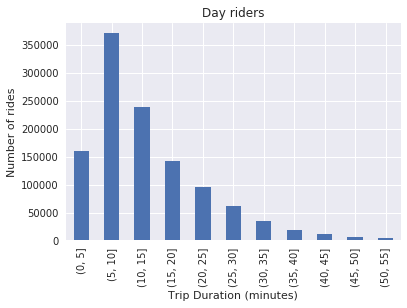

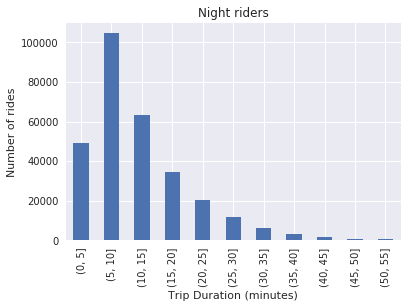

In [69]:
# Histogram Plots
bins = np.arange(0, 59, 5)

axD = df[df['day_or_night'] == 'day'].tripduration.groupby(pd.cut(df[df['day_or_night'] == 'day'].tripduration_minutes, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False)
axD.set_title("Day riders")
axD.set_xlabel("Trip Duration (minutes)")
axD.set_ylabel("Number of rides")

axN = df[df['day_or_night'] == 'night'].tripduration.groupby(pd.cut(df[df['day_or_night'] == 'night'].tripduration_minutes, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axN.set_title("Night riders")
axN.set_xlabel("Trip Duration (minutes)")
axN.set_ylabel("Number of rides")

pl.show()

**Figure 1: Histogram with the distribution of trip durations by day and night.** This histograms show that the distribution of trip durations between day and night is fairly similar in shape, but night rides are have proportionally lower longer rides.

                      count_nonzero
tripduration_minutes               
(0, 5]                     0.025685
(5, 10]                    0.054223
(10, 15]                   0.058098
(15, 20]                   0.049334
(20, 25]                   0.034567
(25, 30]                   0.021064
(30, 35]                   0.012553
(35, 40]                   0.008015
(40, 45]                   0.004140
(45, 50]                   0.002026
(50, 55]                   0.000000


/opt/conda/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


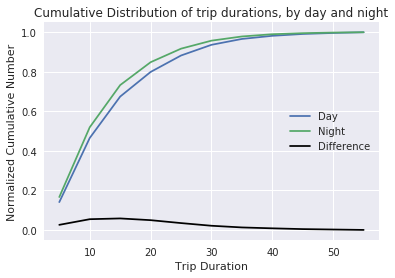

In [70]:
csD=df[df['day_or_night'] == 'day'].tripduration.groupby(pd.cut(df[df['day_or_night'] == 'day'].tripduration_minutes, bins)).agg([count_nonzero]).cumsum()

csN=df[df['day_or_night'] == 'night'].tripduration.groupby(pd.cut(df[df['day_or_night'] == 'night'].tripduration_minutes, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "Day")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "Night")
pl.plot(bins[:-1] + 5, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "Difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.title("Cumulative Distribution of trip durations, by day and night")
pl.legend()
pl.show()

**Figure 2: Cummulative distribution of trip durations, by day and night.** This graph again shows that the normalized cummulative distribution of night trips gets higher than that of day trips, up to around 6-7%. 

### KS tests to compare 2 samples

In [71]:
#Run the ks test
scipy.stats.ks_2samp(df[df['day_or_night'] == 'day'].tripduration, df[df['day_or_night'] == 'night'].tripduration)

Ks_2sampResult(statistic=0.064557720983361766, pvalue=0.0)

We get a p-value < 0.05, so we can reject our null hypothesis. This means that, at a significance level of 0.05, the two samples come from a different distribution. The distribution of trip durations during the night are different than those during the day.

#### Now with only 200 datapoints from each sample

In [78]:
#Let's set the seed for reproductibility
np.random.seed(99)

#Let's draw the samples
day_sample = np.random.choice(df[df['day_or_night'] == 'day'].tripduration, size=200, replace=False)
night_sample = np.random.choice(df[df['day_or_night'] == 'night'].tripduration, size=200, replace=False)

In [79]:
#Run the ks test again on the smaller samples
scipy.stats.ks_2samp(day_sample, night_sample)

Ks_2sampResult(statistic=0.08500000000000002, pvalue=0.44856216357893425)

Now get a p-value > 0.05, so we can't reject our null hypothesis. This means that, at a significance level of 0.05, we can't reject that the two samples come from the same distribution.

It makes sense that we are having more difficulty rejecting the null hypothesis, because we are now using way smaller samples than before. For the KS test, now it can't recognize that the two samples come from a different distribution.

### Pearson's test for correlation

Pearson (and Spearman's) are test to see if two samples are correlated. It does the comparison pairwise, so we have to sort our samples in some way that makes sense.

I decided to sort the trips by time during the day (or night), so the pairs would be the first trip in the night with the first trip in the day, and then the second, third, and so on.

The Null Hypothesis for this tests would be:

$H_0$: The trip durations along the day are not correlated with the trip durations along the night, with significance 0.05.

In [80]:
#We need to first get the samples.
#Here I'm using getting a sample of the dataframe, so then I can sort the rows by other columns than trip duration
day_sample = df[df['day_or_night'] == 'day'].sample(n=200, replace=False)
night_sample = df[df['day_or_night'] == 'night'].sample(n=200, replace=False)

In [86]:
#I'm going to sort by time during the day to run the correlation, so we get the time from the starttime column
day_sample['time'] = day_sample['starttime_converted'].apply(lambda x: x.time())
night_sample['time'] = night_sample['starttime_converted'].apply(lambda x: x.time())

In [88]:
#Sort the rows
day_sample.sort_values(by='time',inplace=True)
night_sample.sort_values(by='time',inplace=True)

In [89]:
#Run Pearson's test
scipy.stats.pearsonr(day_sample.tripduration, night_sample.tripduration)

(-0.013200914409520377, 0.85281568182757184)

We get a correlation very close to 0. Also our p-value is (much) higher than 0.05, so we are unable to reject the null hypothesis.

### Spearman's test for correlation

In [91]:
#Run Spearman's test
scipy.stats.spearmanr(day_sample.tripduration, night_sample.tripduration)

SpearmanrResult(correlation=-0.070039980094453794, pvalue=0.32437010117186582)

Again, we get a correlation very close to 0. Also our p-value is higher than 0.05, so we are unable to reject the null hypothesis.

There isn't much evidence to think that the trip durations along the day would be correlated with the trip durations along the day, so it makes sense that we got these results.